In [1]:
import tensorflow as tf
from util import *
from util.parser import *
from util.img_kit import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (10.0, 10) # set default size of plots


In [2]:
""" Load data """
img_folder = "data/moving-box/frames/square"
# img_folder = "data/moving-box/frames/moving-two-box-uniform"
# img_folder = "data/kid-conversation"
# img_folder = "data/kid-swing"
imgs = [p[2] for p in walk(img_folder)][0]
imgs = list(filter(lambda x: not x.startswith("."), imgs))
prefix, postfix = imgs[0].split("-")[0], imgs[0].split(".")[1]
print("Total Images: {}".format(len(imgs)))
print("From:         {}".format(imgs[0]))
print("To:           {}".format(imgs[-1]))

Total Images: 131
From:         square-001.jpeg
To:           square-131.jpeg


In [179]:
gap = 3
base_index = parse_img_index(imgs[0])
to = parse_img_index(imgs[-1]) - (len(imgs)-1)%(gap + 1)
num_intervals = (to-base_index)//(gap + 1)

print("Select Range:  {} -> {} | {} Intervals".format(base_index, to, num_intervals))

Select Range:  1 -> 129 | 32 Intervals


In [180]:
def index_to_img(i):
    return "{}/{}-{}.{}".format(img_folder, prefix, "%03d"%(base_index + i), postfix)

In [181]:
x_index = [i*(gap+1) for i in range(num_intervals + 1)]
mid_index = [x + (gap+1)//2 for x in x_index[:-1]]
X_train = np.concatenate([misc.imread(index_to_img(i))[np.newaxis, ...] for i in x_index], axis=0)
y_train = np.concatenate([misc.imread(index_to_img(i))[np.newaxis, ...] for i in mid_index], axis=0)
X_train = X_train.astype('float32')
y_train = X_train.astype('float32')
# mean_image = np.mean(X_train, axis = 0)
# X_train -= mean_image
# y_train -= mean_image
# X_train /= 255
# y_train /= 255
#y = [misc.imread(index_to_img(i)) for i in mid_index]  # ground truth of images in betwen
print("Image shape: {}".format(X_train[0].shape))
print(X_train.shape)
print(y_train.shape)

Image shape: (256, 256, 3)
(33, 256, 256, 3)
(33, 256, 256, 3)


In [185]:
batch_size = 6

In [186]:
def sample():
    """
    Select a batch size of data-point from X and y
    """
    start = np.random.choice(list(range(num_intervals)), size = batch_size)
    start_x = X_train[start,:,:,:]
    end_x = X_train[start + 1,:,:,:]
    mean = (start_x + end_x)/2
    start_x -= mean
    end_x -= mean
    batch_x = np.concatenate([start_x,end_x], axis = 3)
    batch_y = y_train[start,:,:,:] - mean
    return((batch_x, batch_y, mean))

In [187]:
def conv_pool_block(inputs, conv_filter, conv_kernel, pool_size, pool_stride):
    conv1 = tf.layers.conv2d(inputs, 
                             conv_filter, 
                             conv_kernel,
                             padding='same', 
                             activation=tf.nn.relu)
    pooled = tf.layers.max_pooling2d(conv1, pool_size, pool_stride)
    return pooled
def dconv_block(inputs, dconv_filter, dconv_kernel, dconv_strides, activation = None, res_conv = None):
    if activation == 'ReLu':
        dconv = tf.layers.conv2d_transpose(inputs, 
                                       filters = dconv_filter, 
                                       kernel_size = dconv_kernel, 
                                       strides = dconv_strides, 
                                       padding='same',
                                       activation=tf.nn.relu)
    else:
        dconv = tf.layers.conv2d_transpose(inputs, 
                                       filters = dconv_filter, 
                                       kernel_size = dconv_kernel, 
                                       strides = dconv_strides, 
                                       padding='same')
    if res_conv is None:
        return dconv
    conv_concat = tf.concat([dconv, res_conv],3)
    return conv_concat

In [188]:
tf.reset_default_graph()
def my_model(X,y):
    block1 = conv_pool_block(X, 24, (3,3), (2,2), (2,2))  #(N, 128, 128, 24)
    block2 = conv_pool_block(block1, 48, (3,3), (2,2), (2,2))  #(N, 64, 64, 48)
    block3 = conv_pool_block(block2, 96, (3,3), (2,2), (2,2))  #(N, 32, 32, 96)
    block4 = conv_pool_block(block3, 192, (3,3), (2,2), (2,2))  #(N, 16, 16, 192)
    dconv_block1 = dconv_block(block4, 96, (3,3), (2,2), 'ReLu', block3) #(N, 32, 32, 192)
    dconv_block2 = dconv_block(dconv_block1, 48, (3,3), (2,2), 'ReLu',block2) #(N, 64, 64, 96)
    dconv_block3 = dconv_block(dconv_block2, 24, (3,3), (2,2), 'ReLu',block1) #(N, 128, 128, 48)
    y_out = dconv_block(dconv_block3, 3, (3,3),(2,2))
    return y_out

X = tf.placeholder(tf.float32, [None, 256, 256, 6])
y = tf.placeholder(tf.float32, [None, 256, 256, 3])

learning_rate = 3e-3
y_out = my_model(X,y)

mean_loss = tf.reduce_mean(tf.nn.l2_loss(y_out - y))
optimizer = tf.train.AdamOptimizer(learning_rate)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

pass

batch : 0  loss: 1.930e+07
batch : 5  loss: 7.130e+06
batch : 10  loss: 3.272e+06
batch : 15  loss: 2.429e+06
batch : 20  loss: 1.572e+06
batch : 25  loss: 1.085e+06
batch : 30  loss: 9.797e+05
batch : 35  loss: 6.762e+05
batch : 40  loss: 6.103e+05
batch : 45  loss: 4.651e+05
batch : 50  loss: 7.143e+05
batch : 55  loss: 6.457e+05
batch : 60  loss: 5.350e+05
batch : 65  loss: 5.629e+05
batch : 70  loss: 4.799e+05
batch : 75  loss: 5.276e+05
batch : 80  loss: 3.621e+05
batch : 85  loss: 3.914e+05
batch : 90  loss: 5.161e+05
batch : 95  loss: 3.793e+05


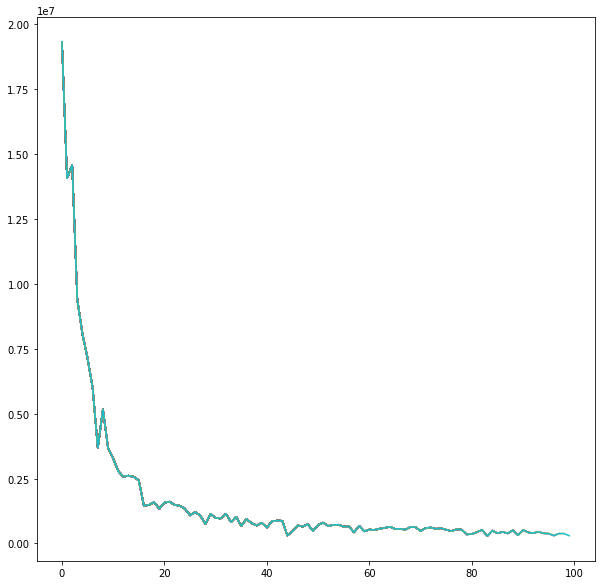

In [189]:
epochs = 100
sess =  tf.Session()
sess.run(tf.global_variables_initializer())
variables = [mean_loss,train_step]
history = []
for e in range(epochs):
    sampled = sample()
    feed_dict = {X: sampled[0], y: sampled[1]}
    loss, _ = sess.run(variables,feed_dict=feed_dict)
    history.append(loss)
    if e % 5 == 0:
        print('batch : {0}  loss: {1:.3e}'.format(e, loss))
    plt.plot(history)

In [190]:
return_variables = [mean_loss, y_out]
sampled = sample()
feed_dict = {X: sampled[0], y: sampled[1]}
result = sess.run(return_variables, feed_dict=feed_dict)
print(result[0])

353768.0


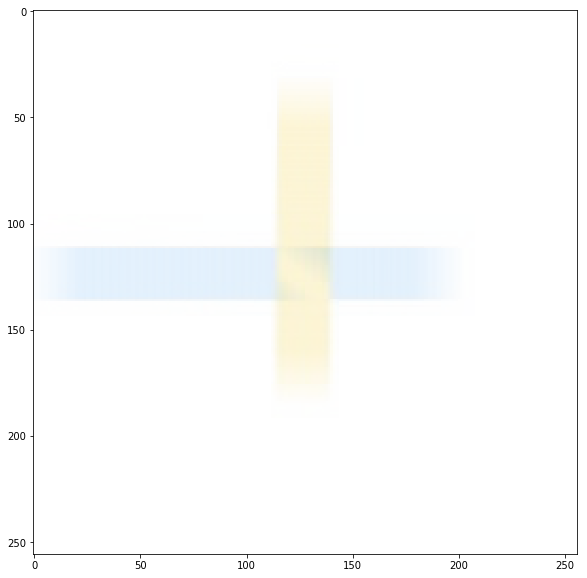

In [191]:
plt.imshow((mean_image).astype('uint8'))

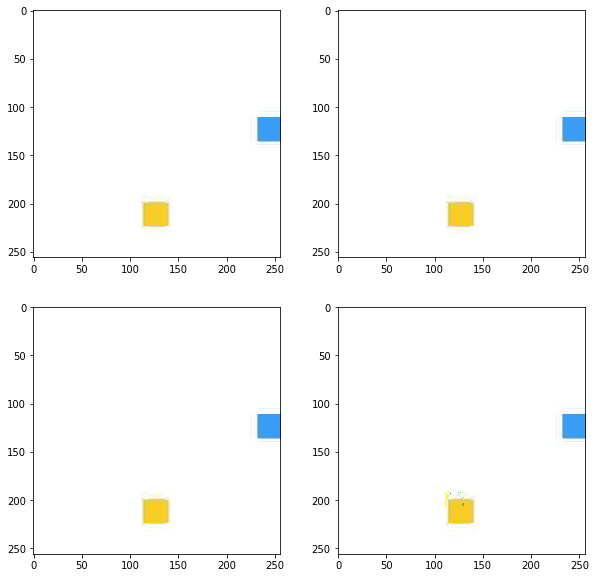

In [192]:
test_ind = 0
plt.subplot(221)
plt.imshow((sampled[0][test_ind,:,:,:3]+sampled[2][test_ind,:,:,:3]).astype('uint8'))
plt.subplot(222)
plt.imshow((sampled[0][test_ind,:,:,3:]+sampled[2][test_ind,:,:,:3]).astype('uint8'))
plt.subplot(223)
plt.imshow((sampled[1][test_ind,:,:,:]+sampled[2][test_ind,:,:,:3]).astype('uint8'))
plt.subplot(224)
y_pred = result[1]
plt.imshow((y_pred[test_ind,:,:,:]+sampled[2][test_ind,:,:,:3]).astype('uint8'))

In [154]:
(y_pred[test_ind,:,:,:]+mean_image).astype('uint8')

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ..., 
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ..., 
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ..., 
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ..., 
       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ..., 
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ..., 
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ..., 
        [254, 254, 254],
        [254, 254, 254],
        [254, 254,